<a href="https://colab.research.google.com/github/IhsanRafli/AquaTeck/blob/main/M1_Kecerdasan_Buatan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, platform, sys, subprocess, warnings, logging
warnings.filterwarnings("ignore", message=r".*HF_TOKEN.*")
os.environ["TOKENIZERS_PARALLELISM"] = "false"
logging.getLogger("transformers").setLevel(logging.ERROR)
logging.getLogger("huggingface_hub").setLevel(logging.ERROR)
print("Python:", platform.python_version())
print("Executable:", sys.executable)
try:
    import torch
    print("PyTorch:", torch.__version__)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Device:", device)
    if device == "cuda":
        print("GPU:", torch.cuda.get_device_name(0))
except Exception:
    print("PyTorch belum terpasang — akan dipasang di sel berikut.")
print("\n=== nvidia-smi ===")
try:
    out = subprocess.check_output(["bash","-lc","nvidia-smi || true"]).decode()
    print(out)
except Exception:
    print("nvidia-smi tidak tersedia.")

Python: 3.12.11
Executable: /usr/bin/python3
PyTorch: 2.8.0+cu126
Device: cpu

=== nvidia-smi ===



In [1]:
!pip -q install numpy pandas scikit-learn matplotlib plotly torch torchvision torchaudio transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os, textwrap, pathlib
BASE = "/content/drive/MyDrive/trpl-ai-capstone"  # Ubah bila perlu
for sd in ["data","notebooks","src","docs"]:
    os.makedirs(os.path.join(BASE, sd), exist_ok=True)
print("Struktur terbentuk di:", BASE)

# .gitignore minimal
gitignore = textwrap.dedent('''
# data & cache
data/
*.cache/
__pycache__/
*.ipynb_checkpoints/
.DS_Store

# secrets
.env
secrets.json
''')
with open(os.path.join(BASE, ".gitignore"), "w") as f:
    f.write(gitignore)
print(".gitignore dibuat.")

Struktur terbentuk di: /content/drive/MyDrive/trpl-ai-capstone
.gitignore dibuat.


Using Colab cache for faster access to the 'daily-coffee-transactions' dataset.
Path: /kaggle/input/daily-coffee-transactions
Isi folder: ['Coffe_sales.csv']
 Sedang melakukan Grid Search, mohon tunggu...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

 Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}

Random Forest (Tuned) Accuracy: 0.6507
                     precision    recall  f1-score   support

          Americano       0.78      0.86      0.82       128
Americano with Milk       0.99      0.99      0.99       163
         Cappuccino       0.33      0.34      0.34        90
              Cocoa       0.36      0.18      0.24        45
            Cortado       0.53      0.42      0.47        48
           Espresso       1.00      0.80      0.89        20
      Hot Chocolate       0.42      0.22      0.29        60
              Latte       0.50      0.66      0.57       156

           accuracy              

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/xgboost/t


XGBoost Accuracy: 0.6268
                     precision    recall  f1-score   support

          Americano       0.79      0.74      0.76       128
Americano with Milk       0.99      0.99      0.99       163
         Cappuccino       0.36      0.36      0.36        90
              Cocoa       0.33      0.29      0.31        45
            Cortado       0.42      0.48      0.45        48
           Espresso       1.00      0.95      0.97        20
      Hot Chocolate       0.35      0.30      0.32        60
              Latte       0.49      0.54      0.51       156

           accuracy                           0.63       710
          macro avg       0.59      0.58      0.58       710
       weighted avg       0.63      0.63      0.63       710



/tmp/ipython-input-3071233553.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis')


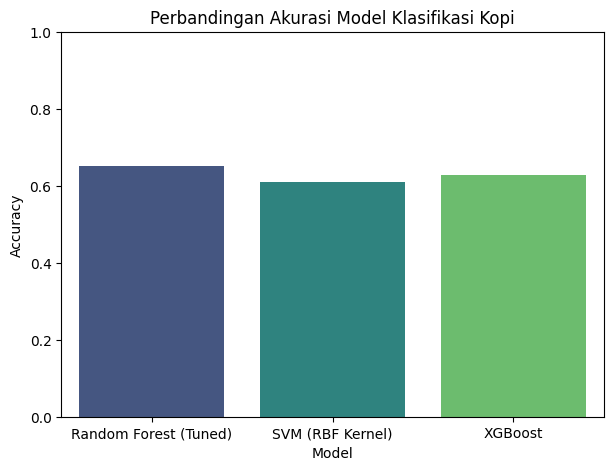

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import kagglehub
import os

# Download dataset
path = kagglehub.dataset_download("minahilfatima12328/daily-coffee-transactions")
print("Path:", path)
print("Isi folder:", os.listdir(path))

# Baca file
df = pd.read_csv(path + "/Coffe_sales.csv")

# Encode kolom teks tambahan biar bisa dipakai sebagai fitur
label_cols = ['cash_type', 'Time_of_Day', 'Weekday', 'Month_name']
for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Pilih fitur dan target
X = df[['hour_of_day', 'money', 'Weekdaysort', 'Monthsort',
        'cash_type', 'Time_of_Day', 'Weekday', 'Month_name']]
y = df['coffee_name']

# Encode target
le_y = LabelEncoder()
y = le_y.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# GridSearchCV untuk Random Forest

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42),
                    param_grid, cv=3, n_jobs=-1, verbose=1)

print(" Sedang melakukan Grid Search, mohon tunggu...")
grid.fit(X_train, y_train)

print("\n Best Parameters:", grid.best_params_)
best_rf = grid.best_estimator_

#Bandingkan dengan model lain: SVM & XGBoost
models = {
    'Random Forest (Tuned)': best_rf,
    'SVM (RBF Kernel)': SVC(kernel='rbf', C=2, gamma='scale', probability=True),
    'XGBoost': XGBClassifier(
        n_estimators=200, learning_rate=0.1, max_depth=8, subsample=0.8,
        colsample_bytree=0.8, random_state=42, use_label_encoder=False, eval_metric='mlogloss'
    )
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append({'Model': name, 'Accuracy': acc})
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=le_y.classes_))

# Visualisasi Perbandingan Akurasi
results_df = pd.DataFrame(results)
plt.figure(figsize=(7,5))
sns.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis')
plt.title("Perbandingan Akurasi Model Klasifikasi Kopi")
plt.ylim(0, 1)
plt.show()
